# Import libraries

In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Import train dataset

In [27]:
df = pd.read_csv("src/conversion_data_train.csv")

print("Nb rows / nb columns :", df.shape)
print("")
df.head()

Nb rows / nb columns : (284580, 6)



,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# EDA

In [28]:
# Check basic statistics
df.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


We can see that the maximum value for the age looks too high for the reality, there might be outliers into this variable.

As well, we see that the mean of the target value is very low, that means the most represented class is 0.

In [29]:
# Check if there are missing values
print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [30]:
# Drop lines containing outliers
print('Dropping outliers in Age...')
to_keep = (df['age'] < 100) 
df = df.loc[to_keep,:] 
print('Done. Number of lines remaining : ', df.shape[0])
print()

Dropping outliers in Age...
Done. Number of lines remaining :  284578



In [31]:
# Checking the new maximum
np.max(df['age'])

79

The new maximum seeems now correct.

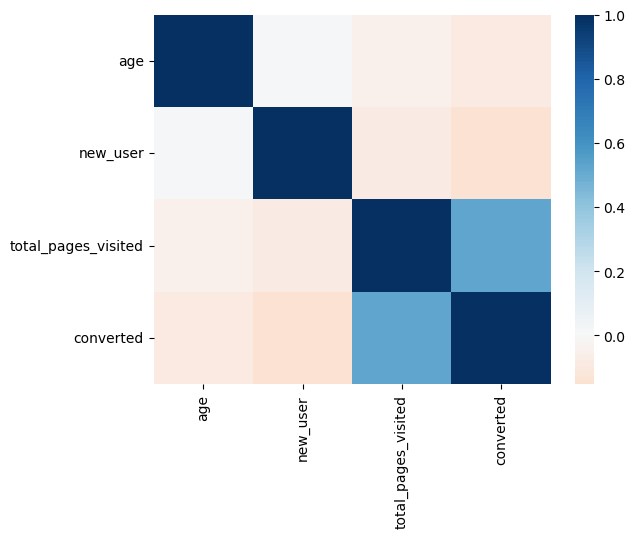

In [7]:
# Display the correlation heatmap
import seaborn as sns

sns.heatmap(df.corr(), cmap='RdBu', center=0)
plt.show()

Only total_pages_visited numeric variable seems to be correlated with our target, so we will only keep this one.

# Separating labels from features

In [32]:
# Separate target variable Y from features X
features_list = ['country', 'source', 'total_pages_visited']
target_variable = 'converted'

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  source  total_pages_visited
0    China  Direct                    2
1       UK     Ads                    3
2  Germany     Seo                   14
3       US     Seo                    3
4       US  Direct                    3


### Features engineering

In [35]:
X['total_pages_visited_2'] = X['total_pages_visited']**2
X['total_pages_visited_3'] = X['total_pages_visited']**3
X['total_pages_visited_4'] = X['total_pages_visited']**4
X['total_pages_visited_inv'] = 1/X['total_pages_visited']
X['total_pages_visited_inv2'] = 1/(X['total_pages_visited']**2)
    
X.head()

,country,source,total_pages_visited,total_pages_visited_2,total_pages_visited_3,total_pages_visited_4,total_pages_visited_inv,total_pages_visited_inv2
0,China,Direct,2,4,8,16,0.500000,0.250000
1,UK,Ads,3,9,27,81,0.333333,0.111111
2,Germany,Seo,14,196,2744,38416,0.071429,0.005102
3,US,Seo,3,9,27,81,0.333333,0.111111
4,US,Direct,3,9,27,81,0.333333,0.111111


In [36]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



# Preprocessings

In [37]:
# Create pipeline for numeric features
numeric_features = ['total_pages_visited', 'total_pages_visited_2', 'total_pages_visited_3', 'total_pages_visited_4', 'total_pages_visited_inv', 'total_pages_visited_inv2']
numeric_transformer = StandardScaler()

In [38]:
# Create pipeline for categorical features
categorical_features = ['country', 'source'] 
categorical_transformer = OneHotEncoder(drop='first')

In [39]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [40]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:]) 
print()

# Remark : no preprocessing needed on the target variable because it already has binary values (0, 1).

Performing preprocessings on train set...
...Done.
[[ 0.0376251  -0.18892041 -0.23062196 -0.1937445  -0.51472098 -0.49630119
   0.          0.          1.          1.          0.        ]
 [-0.2616379  -0.36024305 -0.29829271 -0.21505747 -0.33662232 -0.42540106
   0.          0.          1.          0.          0.        ]
 [-0.86016391 -0.58867324 -0.36041669 -0.22891956  0.55387098  0.16543332
   1.          0.          0.          0.          0.        ]
 [ 0.9354141   0.55347772  0.19869908  0.006736   -0.78186897 -0.57310966
   0.          0.          1.          0.          1.        ]
 [-0.86016391 -0.58867324 -0.36041669 -0.22891956  0.55387098  0.16543332
   0.          0.          1.          0.          1.        ]]

Performing preprocessings on test set...
...Done.
[[-1.15942691 -0.64578079 -0.36818218 -0.22978594  2.33485759  2.52877083
   0.          1.          0.          0.          0.        ]
 [ 0.0376251  -0.18892041 -0.23062196 -0.1937445  -0.51472098 -0.49630119
 

# Train models and compute predictions

In [41]:
# Train models on training set
# Here we have a classification problem

print("Train models...")

logReg = LogisticRegression()
decisionTree = DecisionTreeClassifier()
randomForest = RandomForestClassifier()

logReg.fit(X_train, Y_train)
print("... logistic regression done.")
decisionTree.fit(X_train, Y_train)
print("... decision tree done.")
randomForest.fit(X_train, Y_train)
print("... random forest done.")

Train models...


c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



... logistic regression done.
... decision tree done.
... random forest done.


In [42]:
# Predictions on training set

print("Predictions on training set...")

Y_train_pred_logReg = logReg.predict(X_train)
print("... for logistic regression done.")
Y_train_pred_decisionTree = decisionTree.predict(X_train)
print("... for decision tree done.")
Y_train_pred_randomForest = randomForest.predict(X_train)
print("... for random forest done.")

Predictions on training set...
... for logistic regression done.
... for decision tree done.
... for random forest done.


In [43]:
# Predictions on test set

print("Predictions on test set...")

Y_test_pred_logReg = logReg.predict(X_test)
print("... for logistic regression done.")
Y_test_pred_decisionTree = decisionTree.predict(X_test)
print("... for decision tree done.")
Y_test_pred_randomForest = randomForest.predict(X_test)
print("... for random forest done.")

Predictions on test set...
... for logistic regression done.
... for decision tree done.
... for random forest done.


# Scores

In [44]:
print("Logistic regression, f1-score on train set : ", f1_score(Y_train, Y_train_pred_logReg))
print("Logistic regression, f1-score on test set : ", f1_score(Y_test, Y_test_pred_logReg))
print()
print("Decision tree, f1-score on train set : ", f1_score(Y_train, Y_train_pred_decisionTree))
print("Decision tree, f1-score on test set : ", f1_score(Y_test, Y_test_pred_decisionTree))
print()
print("Random forest, f1-score on train set : ", f1_score(Y_train, Y_train_pred_randomForest))
print("Random forest, f1-score on test set : ", f1_score(Y_test, Y_test_pred_randomForest))

Logistic regression, f1-score on train set :  0.7187986305633364
Logistic regression, f1-score on test set :  0.7100371747211897

Decision tree, f1-score on train set :  0.7196893203883495
Decision tree, f1-score on test set :  0.7099165894346617

Random forest, f1-score on train set :  0.7206007586900983
Random forest, f1-score on test set :  0.7108508014796546



# Scores with cross-validation

In [45]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation 
print("10-fold cross-validation...")
print()
mean_score_logReg_train = cross_val_score(logReg, X_train, Y_train, scoring="f1", cv=5)
mean_score_logReg_test = cross_val_score(logReg, X_test, Y_test, scoring="f1", cv=5)
print('The cross-validated F1 for Logistic regression is : ', mean_score_logReg_train.mean())
print('The cross-validated F1 for Logistic regression is : ', mean_score_logReg_test.mean())
print()
mean_score_decisionTree_train = cross_val_score(decisionTree, X_train, Y_train, scoring="f1", cv=5)
mean_score_decisionTree_test = cross_val_score(decisionTree, X_test, Y_test, scoring="f1", cv=5)
print('The cross-validated F1 for Decsion Tree is : ', mean_score_decisionTree_train.mean())
print('The cross-validated F1 for Decsion Tree is : ', mean_score_decisionTree_test.mean())
print()
mean_score_randomForest_train = cross_val_score(randomForest, X_train, Y_train, scoring="f1", cv=5)
mean_score_randomForest_test= cross_val_score(randomForest, X_test, Y_test, scoring="f1", cv=5)
print('The cross-validated F1 for Random Forest is : ', mean_score_randomForest_train.mean())
print('The cross-validated F1 for Random Forest is : ', mean_score_randomForest_test.mean())

10-fold cross-validation...



c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



The cross-validated F1 for Logistic regression is :  0.7187055803136423
The cross-validated F1 for Logistic regression is :  0.7096599474488553

The cross-validated F1 for Decsion Tree is :  0.7158568958771284
The cross-validated F1 for Decsion Tree is :  0.6960212958621297

The cross-validated F1 for Random Forest is :  0.717067629743801
The cross-validated F1 for Random Forest is :  0.6978878990541353



# Grid Search with Logistic Regression

In [20]:
params = {'C' : np.logspace(-4, 4, 50),
          'penalty' : ['l1', 'l2'] # l1 lasso, l2 ridge
}  
gridsearch_logReg = GridSearchCV(logReg, param_grid = params, cv = 10) 
gridsearch_logReg.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_logReg.best_params_)

c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in

...Done.
Best hyperparameters :  {'C': 0.3906939937054613, 'penalty': 'l2'}


In [21]:
# Predictions on training set
print("Predictions on training set...")
gridSearch_logReg_train_pred = gridsearch_logReg.predict(X_train)
print("...Done.")
print(gridSearch_logReg_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
gridSearch_logReg_test_pred = gridsearch_logReg.predict(X_test)
print("...Done.")
print(gridSearch_logReg_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [22]:
print("f1-score on training set : ", f1_score(Y_train, gridSearch_logReg_train_pred))
print("f1-score on test set : ", f1_score(Y_test, gridSearch_logReg_test_pred))

f1-score on training set :  0.7187986305633364
f1-score on test set :  0.7100371747211897



# Grid Search with Decision Tree

In [23]:
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch_decisionTree = GridSearchCV(decisionTree, param_grid = params, cv = 5) 
gridsearch_decisionTree.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_decisionTree.best_params_)

...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [24]:
# Predictions on training set
print("Predictions on training set...")
gridSearch_decTree_train_pred = gridsearch_decisionTree.predict(X_train)
print("...Done.")
print(gridSearch_decTree_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
gridSearch_decTree_test_pred = gridsearch_decisionTree.predict(X_test)
print("...Done.")
print(gridSearch_decTree_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [25]:
print("f1-score on training set : ", f1_score(Y_train, gridSearch_decTree_train_pred))
print("f1-score on test set : ", f1_score(Y_test, gridSearch_decTree_test_pred))

f1-score on training set :  0.7195898710579463
f1-score on test set :  0.7097372488408037



# Grid Search with Random Forest

In [26]:
# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch_randomForest = GridSearchCV(randomForest, param_grid = params, cv = 3)
gridsearch_randomForest.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_randomForest.best_params_)
print("Best validation accuracy : ", gridsearch_randomForest.best_score_)

...Done.
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Best validation accuracy :  0.9841168040223645


In [27]:
# Predictions on training set
print("Predictions on training set...")
gridSearch_randForest_train_pred = gridsearch_randomForest.predict(X_train)
print("...Done.")
print(gridSearch_randForest_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
gridSearch_randForest_test_pred = gridsearch_randomForest.predict(X_test)
print("...Done.")
print(gridSearch_randForest_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [28]:
print("f1-score on training set : ", f1_score(Y_train, gridSearch_randForest_train_pred))
print("f1-score on test set : ", f1_score(Y_test, gridSearch_randForest_test_pred))

f1-score on training set :  0.7163009404388715
f1-score on test set :  0.7092552196946089



# SVM Model

## Linear SVM

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

In [30]:
print('Training linear SVM...')
svm_linear = SVC(kernel = 'linear')
svm_linear.fit(X_train, Y_train)
print("...Done.")

Training linear SVM...
...Done.


In [31]:
# Predictions on training set
print("Predictions on training set...")
svm_linear_train_pred = svm_linear.predict(X_train)
print("...Done.")
print(svm_linear_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
svm_linear_test_pred = svm_linear.predict(X_test)
print("...Done.")
print(svm_linear_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [32]:
print("f1-score on training set : ", f1_score(Y_train, svm_linear_train_pred))
print("f1-score on test set : ", f1_score(Y_test, svm_linear_test_pred))

f1-score on training set :  0.710078013055246
f1-score on test set :  0.7053994316387748



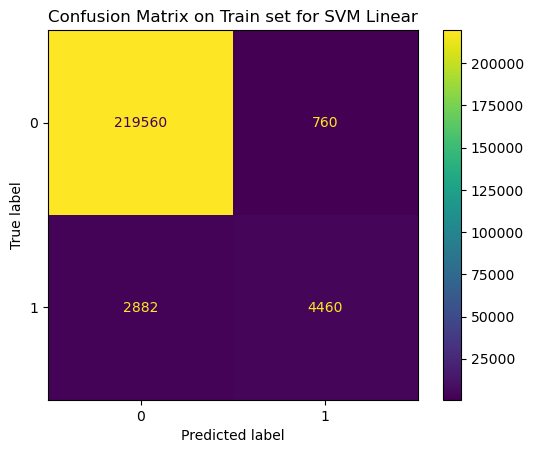

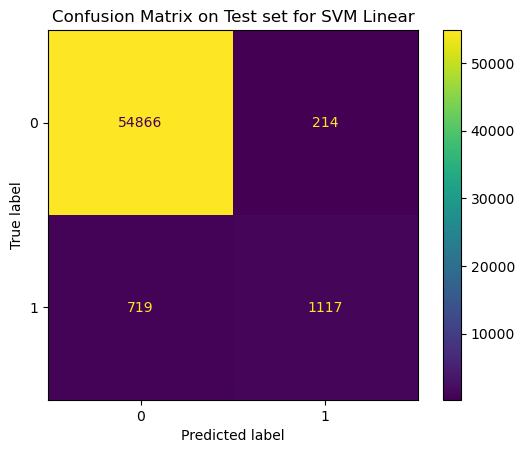

In [33]:
# Visualize confusion matrices
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set for SVM Linear") 
ConfusionMatrixDisplay.from_estimator(svm_linear, X_train, Y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set for SVM Linear") 
ConfusionMatrixDisplay.from_estimator(svm_linear, X_test, Y_test, ax=ax) 
plt.show()

## Non Linear SVM with Grid Search

In [34]:
print('Training no linear SVM...')
svm_non_linear = SVC(kernel = 'rbf')
svm_non_linear.fit(X_train, Y_train)
print("...Done.")

Training no linear SVM...
...Done.


In [35]:
# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}
gridsearch_non_linear_svm = GridSearchCV(svm_non_linear, param_grid = params, cv = 5) 
gridsearch_non_linear_svm.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_non_linear_svm.best_params_)

...Done.
Best hyperparameters :  {'C': 1.0, 'gamma': 1.0}


In [36]:
# Predictions on training set
print("Predictions on training set...")
gridSearch_svm_non_linear_train_pred = gridsearch_non_linear_svm.predict(X_train)
print("...Done.")
print(gridSearch_svm_non_linear_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
gridSearch_svm_non_linear_test_pred = gridsearch_non_linear_svm.predict(X_test)
print("...Done.")
print(gridSearch_svm_non_linear_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [37]:
print("f1-score on training set : ", f1_score(Y_train, gridSearch_svm_non_linear_train_pred))
print("f1-score on test set : ", f1_score(Y_test, gridSearch_svm_non_linear_test_pred))

f1-score on training set :  0.7197827773467804
f1-score on test set :  0.7088607594936709



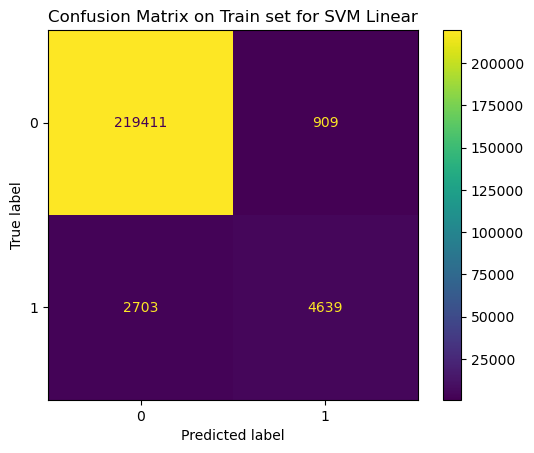

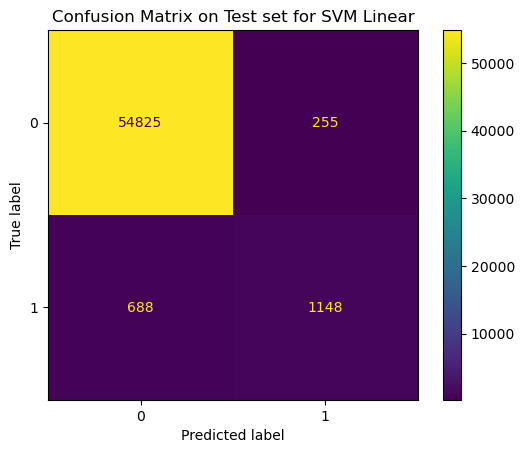

In [38]:
# Visualize confusion matrices
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set for SVM Linear") 
ConfusionMatrixDisplay.from_estimator(gridsearch_non_linear_svm, X_train, Y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set for SVM Linear") 
ConfusionMatrixDisplay.from_estimator(gridsearch_non_linear_svm, X_test, Y_test, ax=ax) 
plt.show()

# Bagging with Logistic Regression

In [49]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

# We take the best hyperparameters we found earlier while doing the grid search on the logisitic regression
logReg_opt = LogisticRegression(C= 0.3906939937054613, penalty= 'l2')
bagging_logReg = BaggingClassifier(base_estimator=logReg_opt, n_estimators = 20)
bagging_logReg.fit(X_train, Y_train)

c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\morgane.berrod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\morgane.berrod\

BaggingClassifier(base_estimator=LogisticRegression(C=0.3906939937054613),
                  n_estimators=20)

In [50]:
# Predictions on training set
print("Predictions on training set...")
bagging_logReg_train_pred = bagging_logReg.predict(X_train)
print("...Done.")
print(bagging_logReg_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
bagging_logReg_test_pred = bagging_logReg.predict(X_test)
print("...Done.")
print(bagging_logReg_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [51]:
print("f1-score on training set : ", f1_score(Y_train, bagging_logReg_train_pred))
print("f1-score on test set : ", f1_score(Y_test, bagging_logReg_test_pred))

f1-score on training set :  0.7187986305633364
f1-score on test set :  0.7100371747211897


# ADABoost with Logistic Regression

In [52]:
ada_logReg = AdaBoostClassifier(logReg_opt)
ada_logReg.fit(X_train, Y_train)
ada_logReg.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(C=0.3906939937054613))

In [53]:
# Predictions on training set
print("Predictions on training set...")
ada_logReg_train_pred = ada_logReg.predict(X_train)
print("...Done.")
print(ada_logReg_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
ada_logReg_test_pred = ada_logReg.predict(X_test)
print("...Done.")
print(ada_logReg_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [54]:
print("f1-score on training set : ", f1_score(Y_train, ada_logReg_train_pred))
print("f1-score on test set : ", f1_score(Y_test, ada_logReg_test_pred))

f1-score on training set :  0.6970509383378016
f1-score on test set :  0.6927654243658002


# ADABoost with Decision Tree

In [59]:
# We take the best hyperparameters we found earlier while doing the grid search on the decsion tree 
decTree_opt = DecisionTreeClassifier(max_depth=10, min_samples_leaf= 5, min_samples_split= 2)
ada_decTree = AdaBoostClassifier(decTree_opt)
ada_decTree.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         min_samples_leaf=5))

In [60]:
# Predictions on training set
print("Predictions on training set...")
ada_decTree_train_pred = ada_decTree.predict(X_train)
print("...Done.")
print(ada_decTree_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
ada_decTree_test_pred = ada_decTree.predict(X_test)
print("...Done.")
print(ada_decTree_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


In [61]:
print("f1-score on training set : ", f1_score(Y_train, ada_decTree_train_pred))
print("f1-score on test set : ", f1_score(Y_test, ada_decTree_test_pred))

f1-score on training set :  0.7197328570319173
f1-score on test set :  0.7099165894346617


# Gradient Boosting 

In [62]:
# Gradient Boosting are only for decision trees, so we take the best hyperparameters we found earlier for the decsion tree 
gradBoost = GradientBoostingClassifier(max_depth=10, min_samples_leaf= 5, min_samples_split= 2)
gradBoost.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=10, min_samples_leaf=5)

In [63]:
# Predictions on training set
print("Predictions on training set...")
gradBoost_train_pred = gradBoost.predict(X_train)
print("...Done.")
print(gradBoost_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
gradBoost_test_pred = gradBoost.predict(X_test)
print("...Done.")
print(gradBoost_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


In [64]:
print("f1-score on training set : ", f1_score(Y_train, gradBoost_train_pred))
print("f1-score on test set : ", f1_score(Y_test, gradBoost_test_pred))

f1-score on training set :  0.7197328570319173
f1-score on test set :  0.7099165894346617


# XGBoost

In [65]:
from xgboost import XGBClassifier

xgBoost = XGBClassifier()

# Grid of values to be tested
# We made a grid search because we add a new hyperparameter (min_child_weight) we do not compute before 
params = {
    'max_depth': [2, 4, 6], 
    'min_child_weight': [1, 2, 3],
    'n_estimators': [2, 4, 6, 8,] 
}

xgBoost = GridSearchCV(xgBoost, param_grid = params, cv = 5)
xgBoost.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

In [66]:
# Predictions on training set
print("Predictions on training set...")
xgBoost_train_pred = xgBoost.predict(X_train)
print("...Done.")
print(xgBoost_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
xgBoost_test_pred = xgBoost.predict(X_test)
print("...Done.")
print(xgBoost_test_pred)

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


In [67]:
print("f1-score on training set : ", f1_score(Y_train, xgBoost_train_pred))
print("f1-score on test set : ", f1_score(Y_test, xgBoost_test_pred))

f1-score on training set :  0.7181166198939818
f1-score on test set :  0.7096374341493648


# Train best classifier on all data and use it to make predictions on X_without_labels

In [47]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

randomForest.fit(X,Y)

RandomForestClassifier()

In [48]:
# Read data without labels
df_without_labels = pd.read_csv('src/conversion_data_test.csv')
print('Prediction set (without labels) :', df_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features used by your best classifier
features_list = ['country', 'source', 'total_pages_visited']
X_without_labels = df_without_labels.loc[:, features_list]
X_without_labels.head()

Prediction set (without labels) : (31620, 5)


,country,source,total_pages_visited
0,UK,Seo,16
1,UK,Direct,5
2,China,Seo,1
3,US,Ads,6
4,China,Seo,3


In [49]:
# Preprocessings
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32951812  0.          1.          0.          0.          1.        ]
 [ 0.0376251   0.          1.          0.          1.          0.        ]
 [-1.15942691  0.          0.          0.          0.          1.        ]
 [ 0.3368881   0.          0.          1.          0.          0.        ]
 [-0.56090091  0.          0.          0.          0.          1.        ]]


In [50]:
data = {
    'converted': randomForest.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('results/conversion_data_test_predictions_MORGANE.csv', index=False)